**Note to grader:** Each question consists of parts, e.g. Q1(i), Q1(ii), etc. Each part must be graded on scale of 0-4 scale, following the standard NJIT convention (A: 4, B+: 3.5, B: 3, C+: 2.5, C: 2, D: 1, F: 0).

The total score must be re-scaled to 100 so that Canvas gives the same weight to Assignments 2-6.

For questions stated as being worth 8 points, grade on a 0-4 scale, and multiply by 2.

In [ ]:
# Grader's area
import numpy as np
M = np.zeros([10,10])
maxScore = 0


# **Assignment 3**

The goal in this assignment to work a little more with Python, do some practice with logistic regression, and reflect on how it can fail to work on linearly separable data. You will also work with a support vector classifier. All that, still on "toy" data sets.

We will work with the first 'real' data sets in the next assignment.

**You may use ChatGPT or other LLMs to help with this assignment.** (Unless the question specifically requests it, the use of LLMs is **optional**.) However, if you do use an LLM to help with a particular question, you must submit a full transcript of all your interactions with the LLM in the form of screenshots embedded in the text cells provided. (Alternatively, if the LLM allows links to the transcripts to be shared, then you can place such links in the text cells instead. Please make sure that the links work!) You must also do this on your own &mdash; using the results of another person's LLM session, or sharing your session with another student, are not acceptable. In your answer, you should also state how you were able to make use of the LLM's responses.

Here is an example of what a ChatGPT transcript looks like. Note that the transcript includes the full output as well as the user prompt that generated the ChatGPT response. Please use a separate text cell for each image you embed.

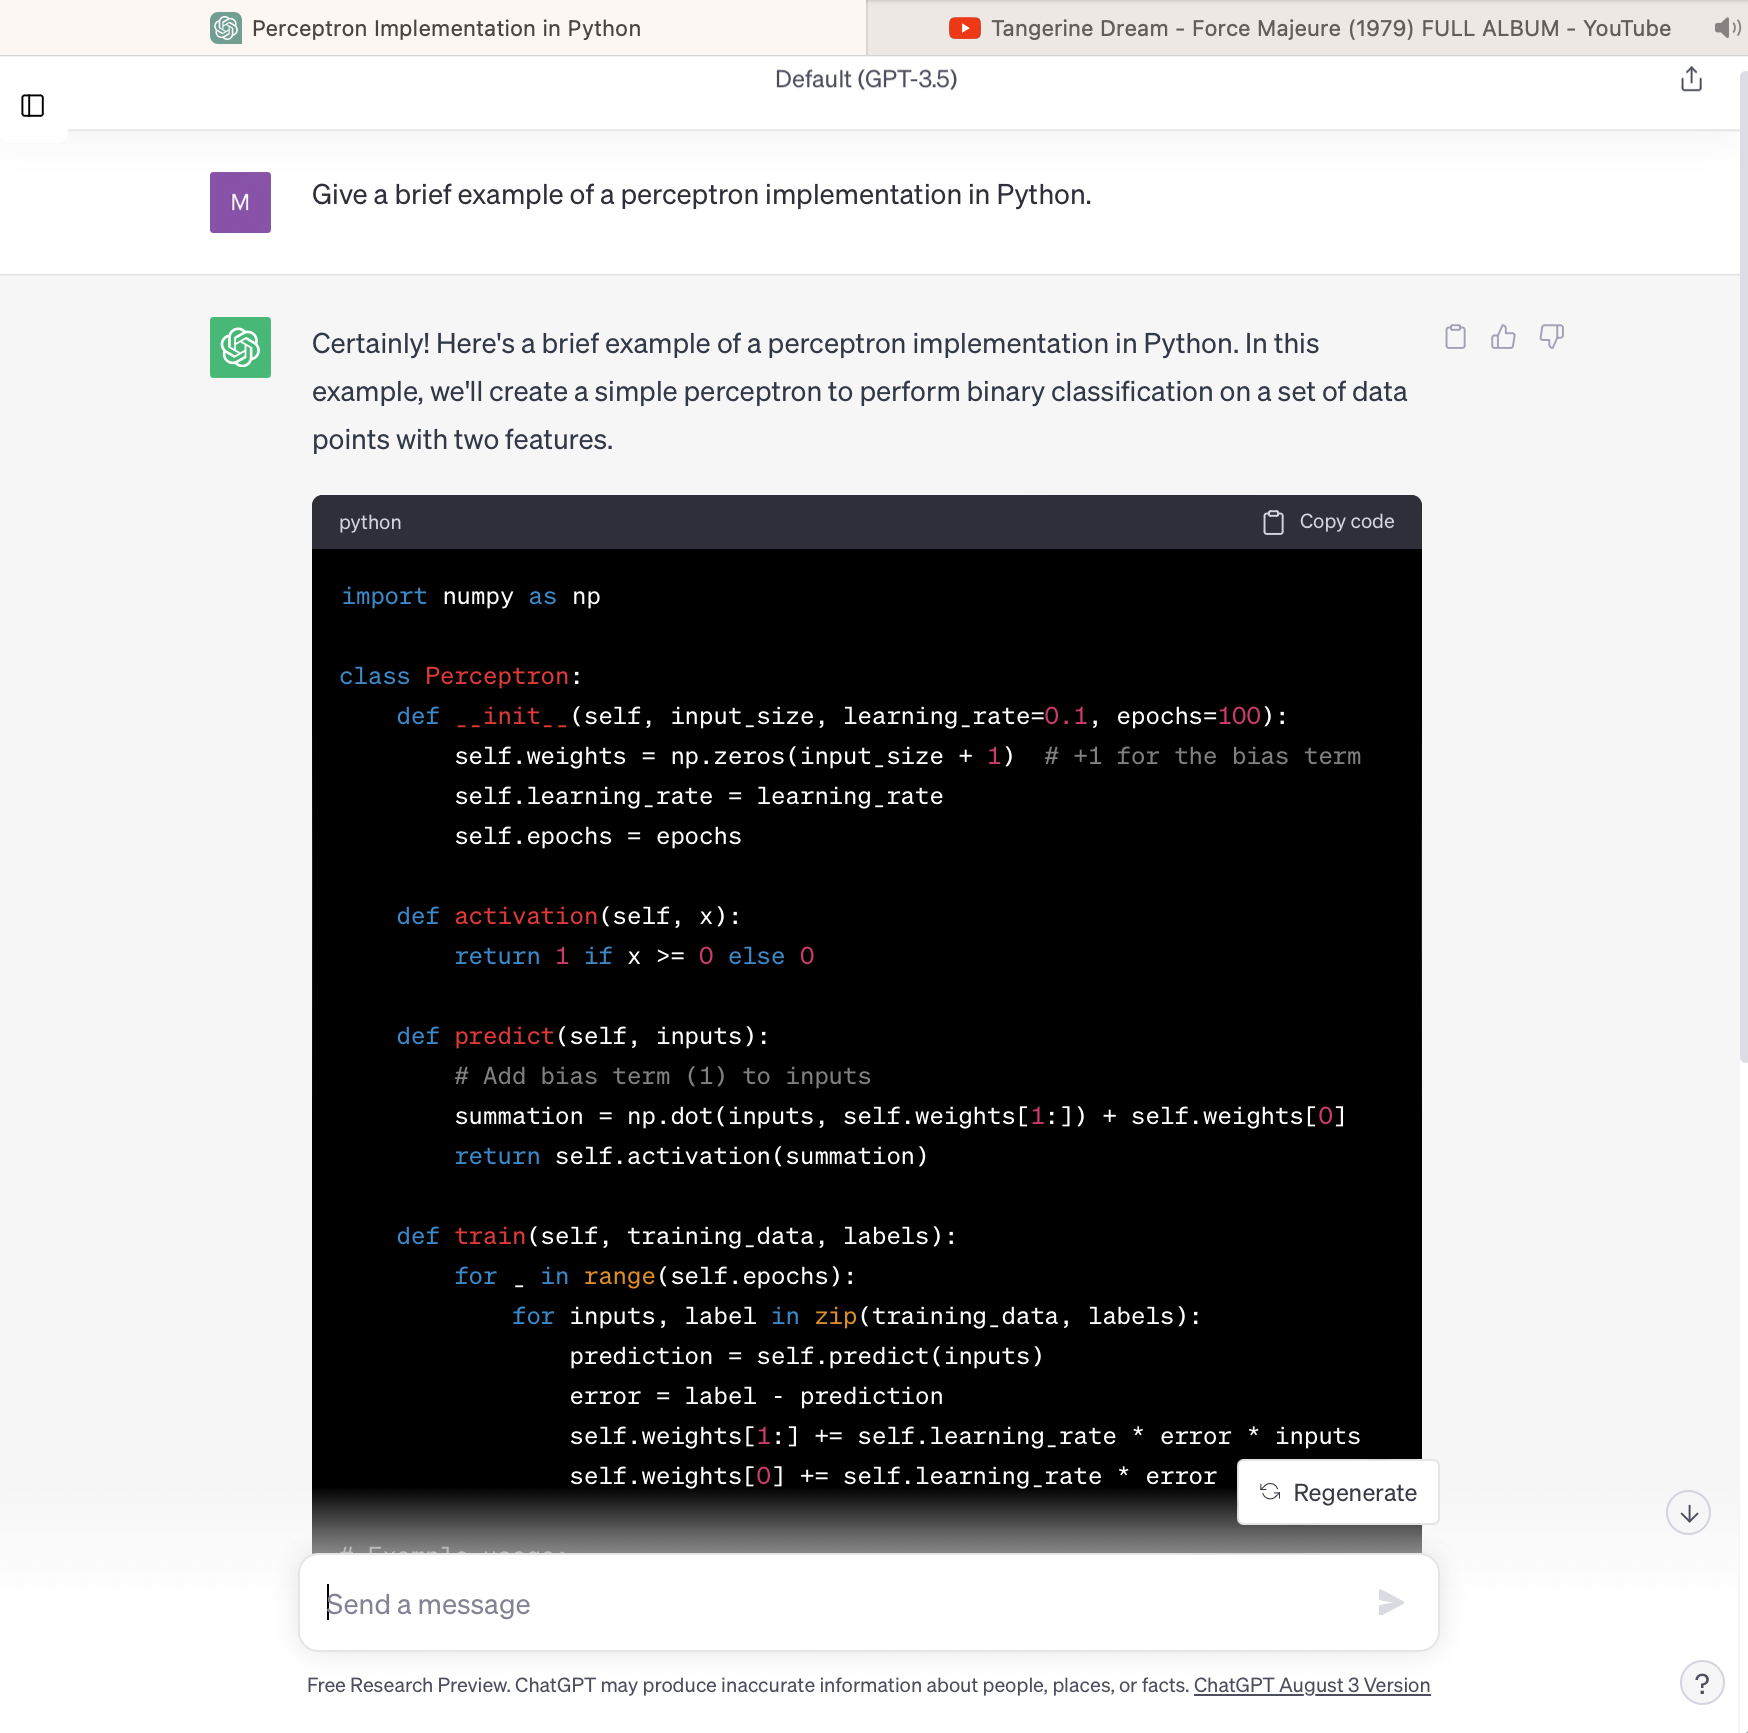

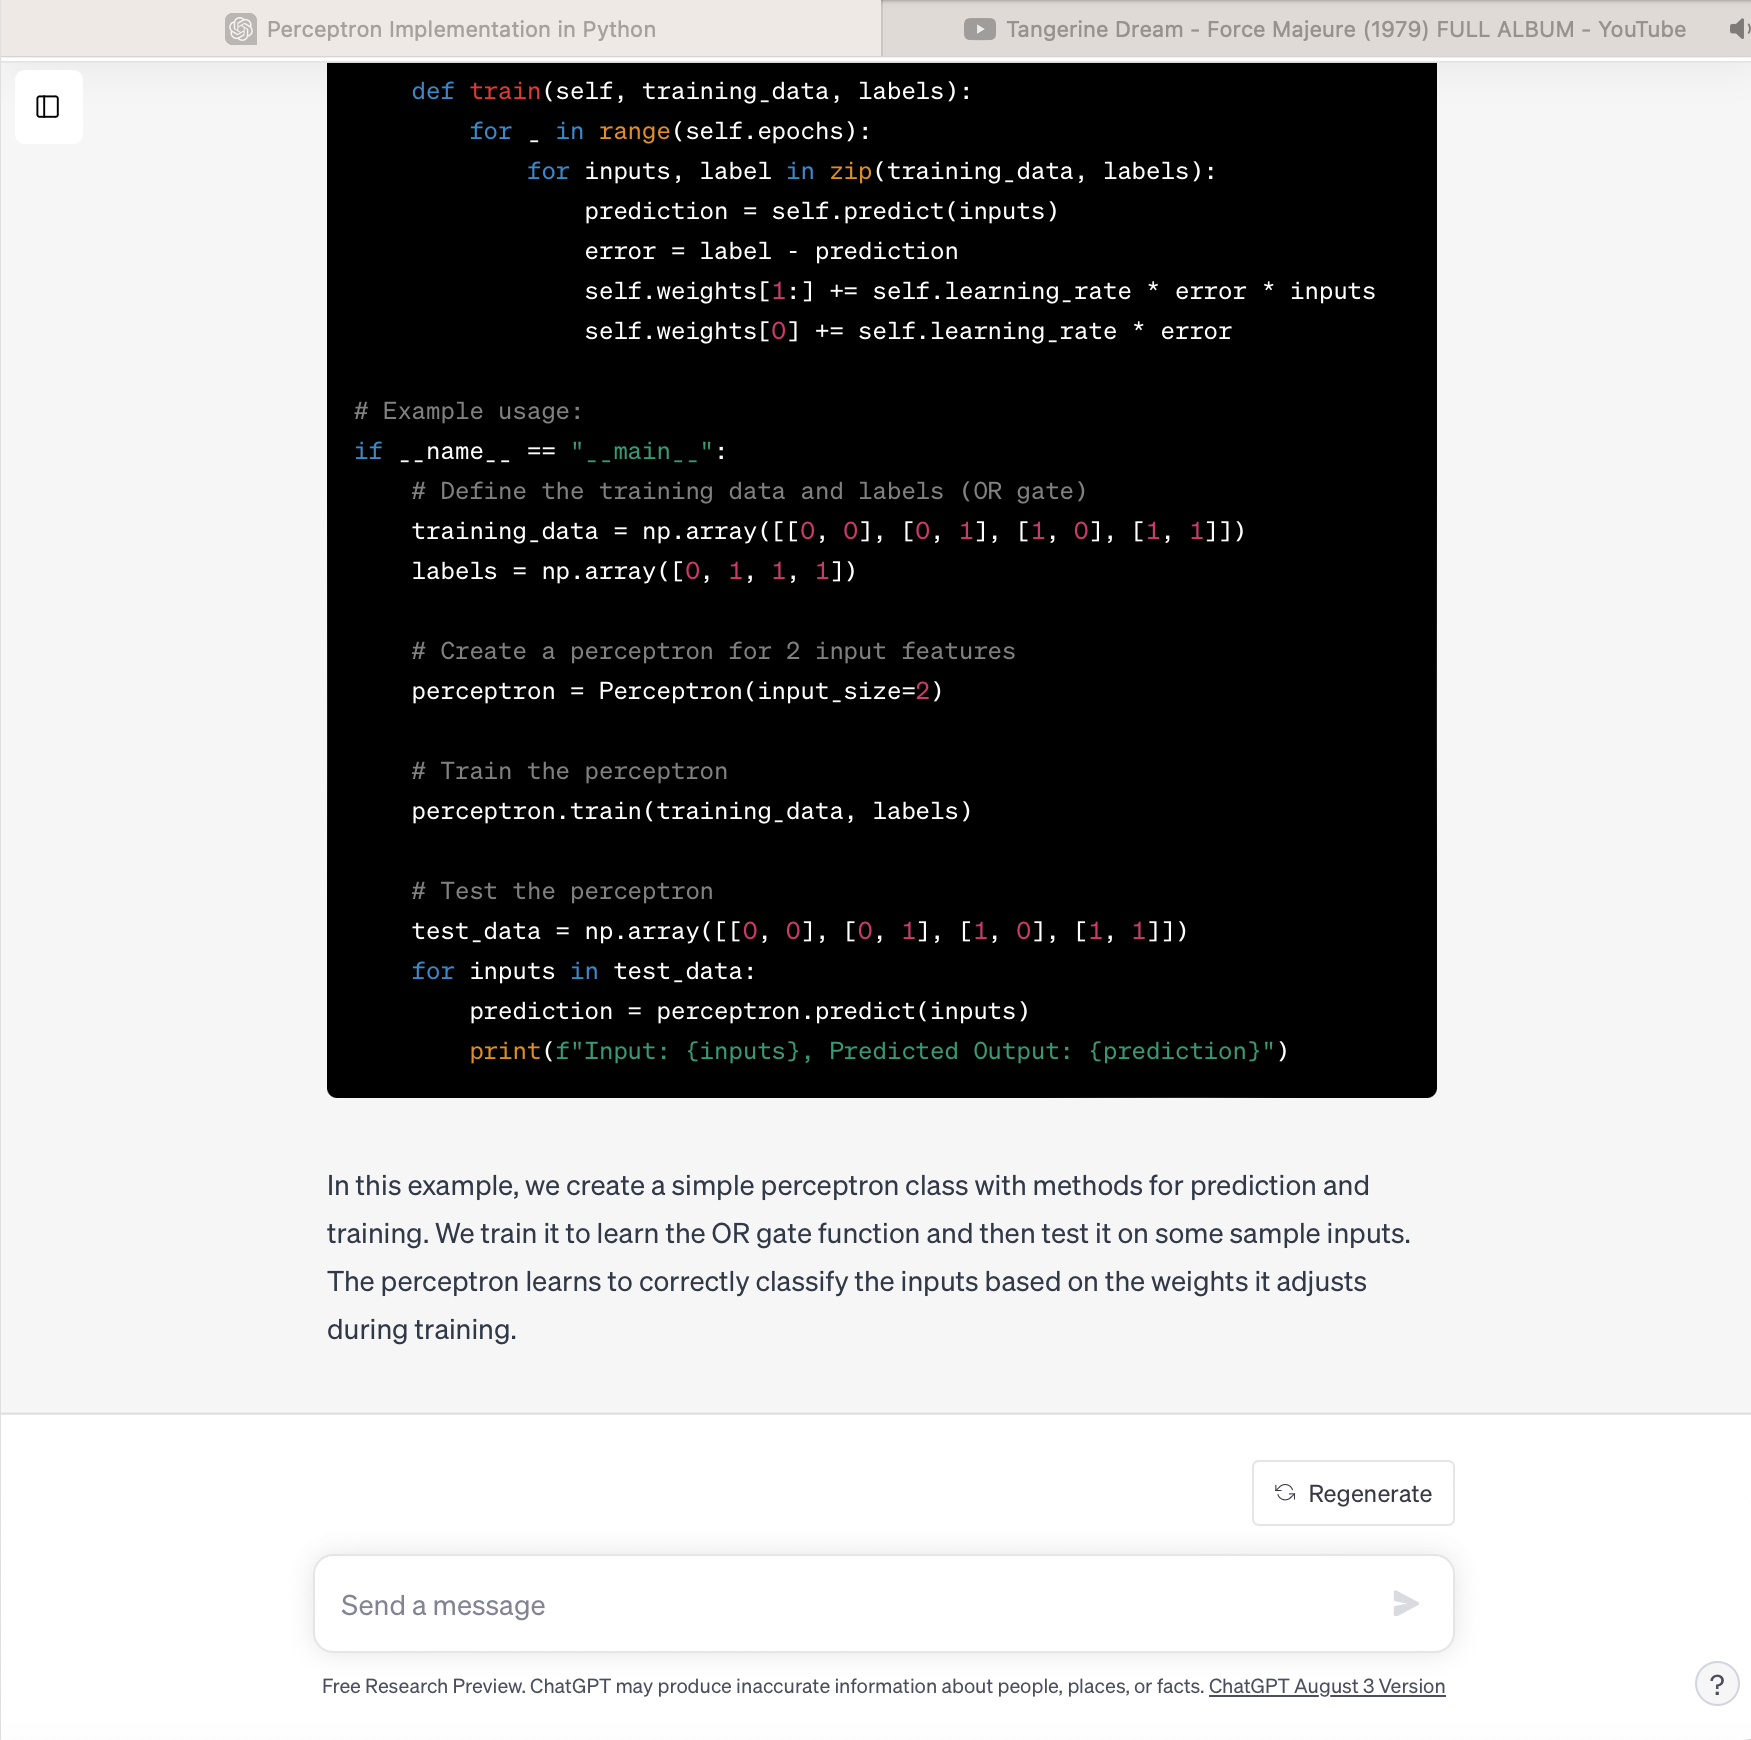

## **Preparation Steps**

In [ ]:
# Import all necessary python packages
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression

In [ ]:
# ### Reading-in the Iris data

s = os.path.join('https://archive.ics.uci.edu', 'ml',
                 'machine-learning-databases', 'iris','iris.data')
s = s.replace("\\","/");
print('URL:', s)
df = pd.read_csv(s,header=None,encoding='utf-8')


URL: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


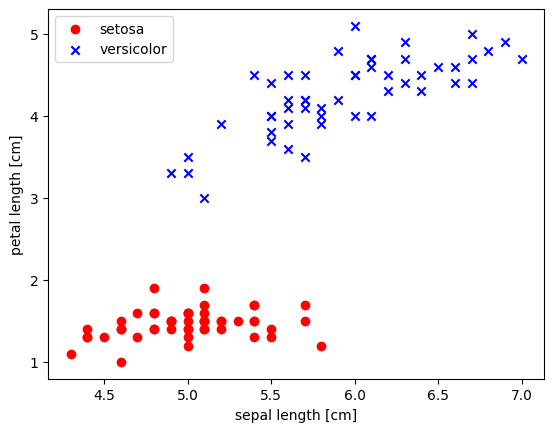

In [ ]:
# select setosa and versicolor for binary classification
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)

# extract sepal length and petal length
X = df.iloc[:100, [0, 2]].values

# plot data
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='x', label='versicolor')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')


# plt.savefig('images/02_06.png', dpi=300)
plt.show()


In [ ]:
# function for visualizing decision regions

from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black')

-----------------------
-----------------------
-----------------------


## <font color = 'blue'> **Question 1. Practice with logistic regression** </font>

First, let's load a slightly modified version of the textbook's implementation of logistic regression with gradient descent.

In [ ]:
class LogisticRegressionGD(object):
    """Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    loss_ : list
      Logistic loss function value in each epoch.

    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.loss_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()

            # Clip the values of 'output' to avoid divide-by-zero errors
            output = np.clip(output, 1e-10, 1 - 1e-10)

            # compute the logistic `loss`
            loss = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.loss_.append(loss)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # equivalent to:
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

Below you can see the first 3 data points of the data set, all labeled as 'setosa'. Let's set the numerical value for 'setosa' to 1. (i.e. y = 1).

In [ ]:
X[0:3]

array([[5.1, 1.4],
       [4.9, 1.4],
       [4.7, 1.3]])

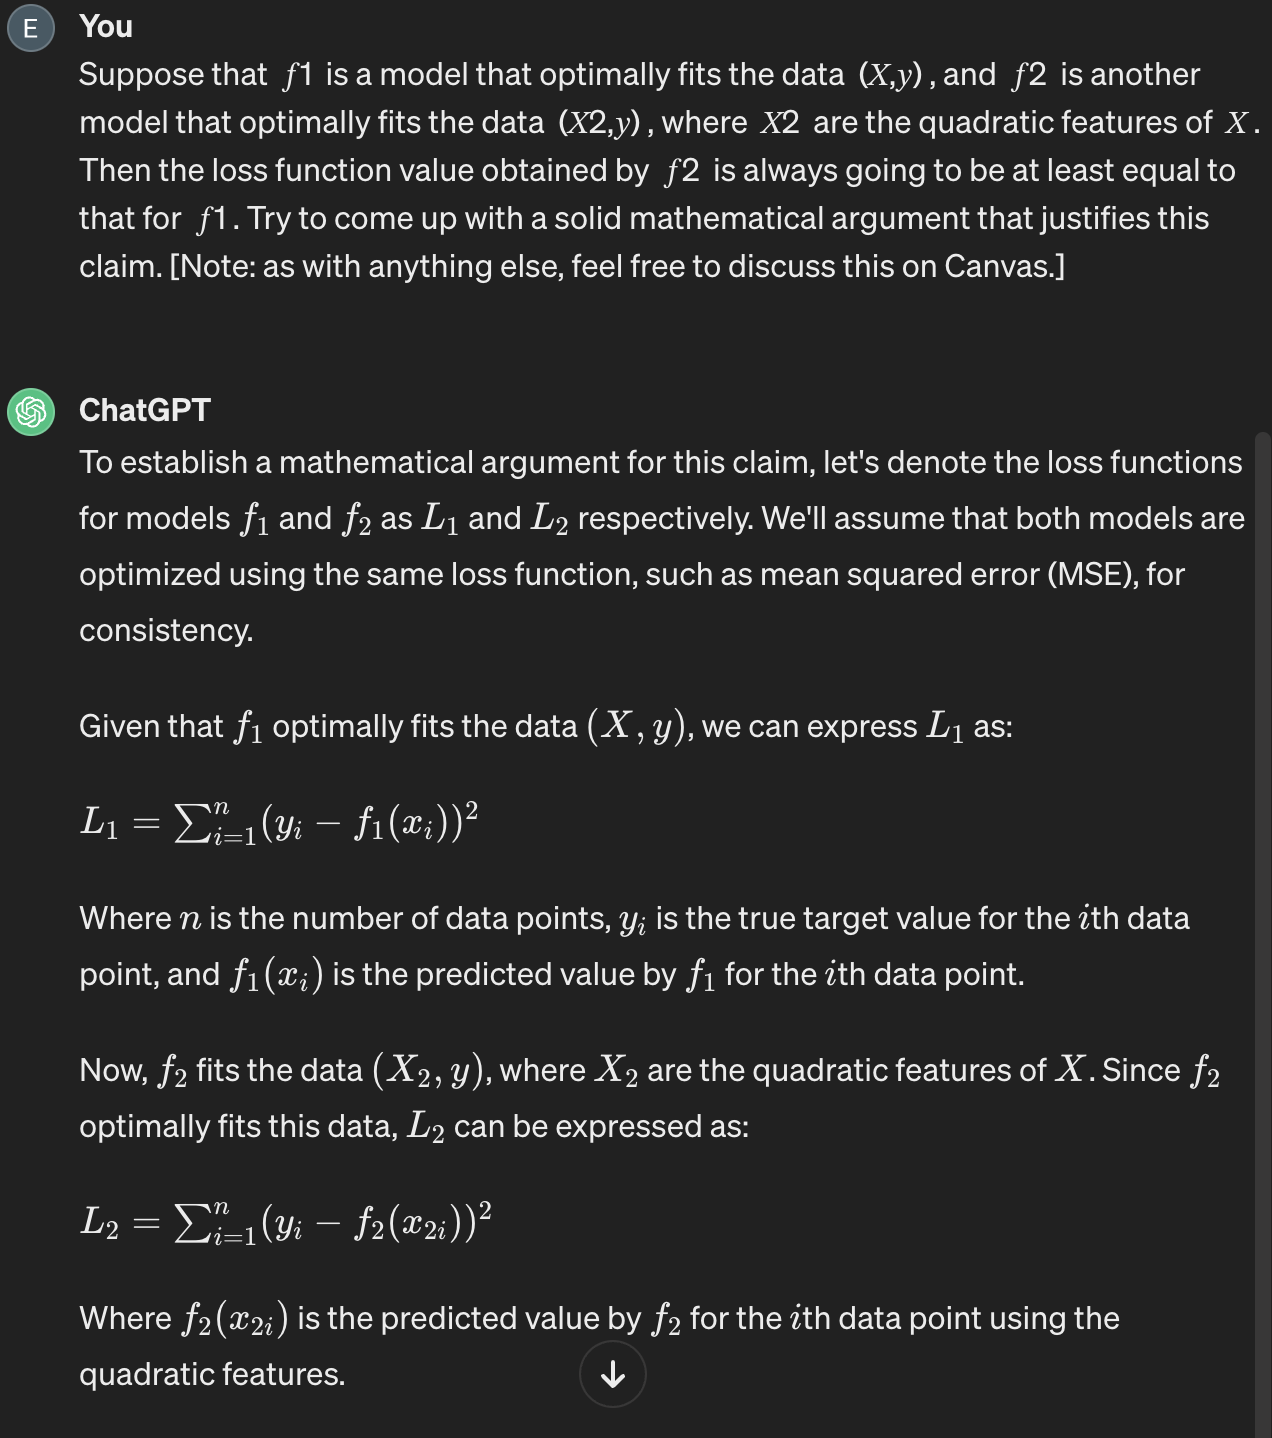Suppose the initial weights of the logistic neuron are w0 = 0.1, w1 = -0.3, w2 = 0.2.

<font color = 'blue'> **Q1-1**.  </font> Write the weights after processing data points 0,1,2, with learning rate $\eta=0.1$ and show your calculations. This is similar to the previous assignment, only done now for the logistic neuron. You can also use *LogisticRegressionGD* to check your calculations. <br>

<font color = 'blue'> **Q1-2**.  </font> Given our data $X$, let $X_{d=2}$ and $X_{d=3}$ be the quadratic and cubic features. Using code for polynomial regression from the Regression Code Notebook, generate $X_{d=2}$ and $X_{d=3}$.

<font color = 'blue'> **Q1-3**.  </font> Using *LogisticRegressionGD*, fit $X$, $X_{d=2}$ and $X_{d=3}$. Here you should set $\eta \leq 0.001$ and $n_{\mathit{iter}} \geq 1000$. For each of these three cases, report the loss function value for the model computed by *LogisticRegressionGD*. Explain why your program produces the loss values you observe.

<font color = 'blue'> **Q1-4**.  </font> Copy the code for our class *LogisticRegressionGD* into a new cell, and modify so that it uses L2 regularization. (**Note:** You will need to update the parameter weight update rule for gradient descent.) Give your copy the new name *LogisticRegressionGDwithReg*, and make sure that every new line of code you add is clearly commented.

<font color = 'blue'> **Q1-5**.  </font>
Redo Q1-3 using *LogisticRegressionGDwithReg* with $\lambda\in\{0.0, 0.1,\ldots, 0.9\}$, for the same input choices and hyperparameter choices from Q1-3. For each case, report the loss function value and the norm of the weight parameter vector. What trends do you observe?

(If for this question you have used LLMs such as ChatGPT, replace this text by screenshots of the full transcript of your session. Create extra text cells if needed.)

Q1-1. The new weights that I have calculated were w0 = 0.2, w1= 0.21, and w2=0.34. I did this on paper.

In [ ]:
#Q1-2.
from sklearn.preprocessing import PolynomialFeatures
y = np.where(y==1,1,0)

# Generate quadratic features
poly = PolynomialFeatures(degree=2)
Xd_2 = poly.fit_transform(X)

# Generate cubic features
poly = PolynomialFeatures(degree=3)
Xd_3 = poly.fit_transform(X)

Q1-3. The code below finds the loss value for each model. After running, the program shows that the lower loss value means better model. Therefore, in this case, the cubic features dataset shows the smallest loss value (8.098623639735117e-06) and best model. This would make sense because a more complex model can better fit the data, but you also lose interpretability.



In [ ]:
# Fitting X of entire dataset
lrgd = LogisticRegressionGD(eta=0.001, n_iter=1000)
lrgd.fit(X, y)
loss_X = lrgd.loss_

# Fitting Xd2
lrgd2 = LogisticRegressionGD(eta=0.001, n_iter=1000)
lrgd2.fit(Xd_2, y)
loss_Xd2 = lrgd2.loss_

# Fitting Xd3
lrgd3 = LogisticRegressionGD(eta=0.001, n_iter=1000)
lrgd3.fit(Xd_3, y)
loss_Xd3 = lrgd3.loss_

print("Loss for X:", loss_X[-1])
print("Loss for Xd2:", loss_Xd2[-1])
print("Loss for Xd3:", loss_Xd3[-1])


Loss for X: 1.4677208967911004
Loss for Xd2: 0.021712137706496246
Loss for Xd3: 8.098623639735117e-06


In [ ]:
#Q1-4. Adding L2 Regression and renaming class
class LogisticRegressionGDwithReg(object):
    def __init__(self, eta=0.05, n_iter=100, random_state=1, lambda_=0.1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        self.lambda_ = lambda_ # added a new property

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.loss_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)

            # adding L2 regularization - weights
            self.w_[1:] *= (1 - self.eta * self.lambda_)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()

            # Avoiding divide-by-zero errors
            output = np.clip(output, 1e-10, 1 - 1e-10)
            loss = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.loss_.append(loss)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)

Q1-5. There is a trend. After my code is implemented to create a graph of "Loss and Weight Norm vs. Regularization Parameter Lambda". You can tell that as lambda increases, so does the loss value. The weight value is inversely proportional to lambda and the loss values.

Lambda: 0.0
  Loss X: 1.4677208967911004, Weight Norm X: 4.5439111761506625
Lambda: 0.1
  Loss X: 1.7017741232329913, Weight Norm X: 4.346882065026542
Lambda: 0.2
  Loss X: 1.9459950102006132, Weight Norm X: 4.169999181961462
Lambda: 0.30000000000000004
  Loss X: 2.1975445866583208, Weight Norm X: 4.010907088667068
Lambda: 0.4
  Loss X: 2.4538204114451516, Weight Norm X: 3.8674778381968142
Lambda: 0.5
  Loss X: 2.712544583557258, Weight Norm X: 3.737808546973558
Lambda: 0.6000000000000001
  Loss X: 2.9718021037865796, Weight Norm X: 3.620212693085612
Lambda: 0.7000000000000001
  Loss X: 3.230041146374044, Weight Norm X: 3.5132066413445178
Lambda: 0.8
  Loss X: 3.4860478256911946, Weight Norm X: 3.415493051560081
Lambda: 0.9
  Loss X: 3.7389065773562646, Weight Norm X: 3.3259426922512123


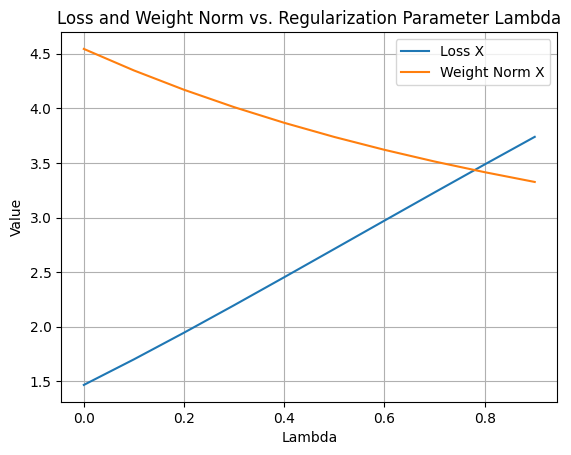

In [ ]:
#Q1-5. Defining lambda values
lambda_values = np.arange(0.0, 1.0, 0.1)

#Storing results for plot
loss_values = []
weight_norms = []

# Fitting models for X for each lambda value
for lambda_val in lambda_values:
    # Fitting model for X
    lrgd_X = LogisticRegressionGDwithReg(eta=0.001, n_iter=1000, lambda_=lambda_val)
    lrgd_X.fit(X, y)
    loss_X = lrgd_X.loss_[-1]
    weight_norm_X = np.linalg.norm(lrgd_X.w_[1:])
    loss_values.append(loss_X)
    weight_norms.append(weight_norm_X)

    # Print results for each lambda
    print(f"Lambda: {lambda_val}")
    print(f"  Loss X: {loss_X}, Weight Norm X: {weight_norm_X}")

# Plotting trends

# Plot loss values
plt.plot(lambda_values, loss_values, label='Loss X')

# Plot weight norms
plt.plot(lambda_values, weight_norms, label='Weight Norm X')

plt.xlabel('Lambda')
plt.ylabel('Value')
plt.title('Loss and Weight Norm vs. Regularization Parameter Lambda')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Grader's area

maxScore = maxScore +4
#M[1,1] =

maxScore = maxScore +4
#M[1,2] =

maxScore = maxScore +4
#M[1,3] =

maxScore = maxScore +4
#M[1,4] =

maxScore = maxScore +4
#M[1,5] =

-----------------------
-----------------------
-----------------------


## <font color = 'blue'> **Question 2. A theoretical question** </font>

This question is about a theoretical explanation for what you observed in question Q1-3.

<br>

Suppose that $f_1$ is a model that optimally fits the data $(X,y)$, and $f_2$ is another model that optimally fits the data $(X_2,y)$, where $X_2$ are the quadratic features of $X$. Then the loss function value obtained by $f_2$ is **always** going to be at least equal to that for $f_1$. Try to come up with a solid mathematical argument that justifies this claim. [**Note:** as with anything else, feel free to discuss this on Canvas.]

I got this answer using ChatGPT. Below is my personal answer as well.

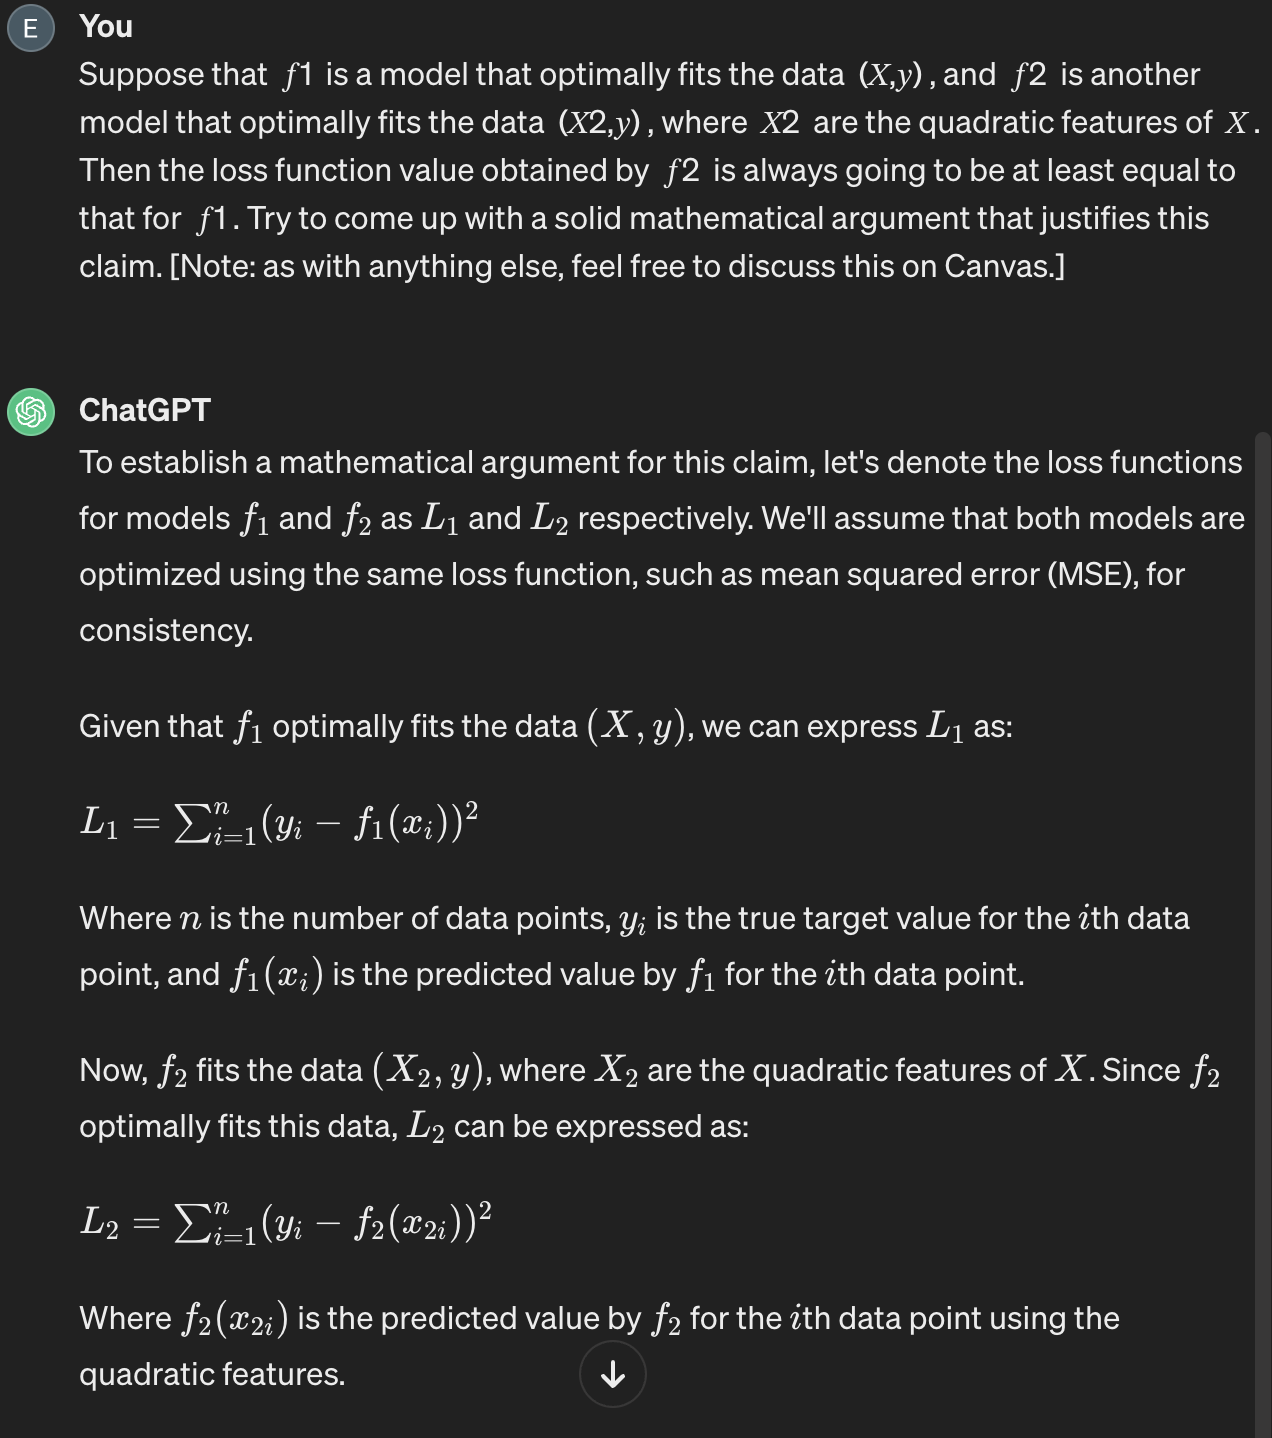

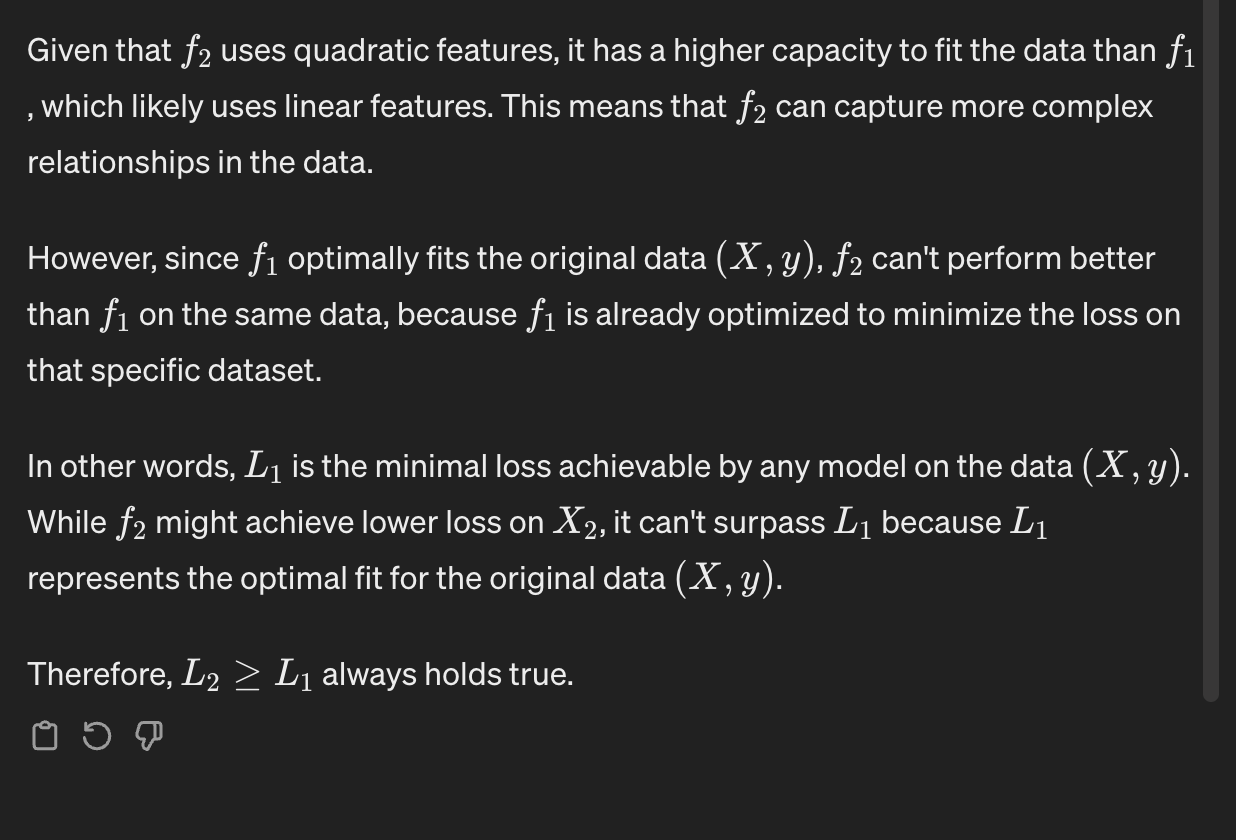

**My Answer:** I believe that adding features would decrease loss. If you compare the origional model and cubic model from Q1-3. You can see that the more complex model would have a smaller loss value. This is because it implies that f2 (the quadratic one)  has access to more informationthan f1. This increased information allows f2 to better capture the underlying patterns in the data and therefore minimize the loss function L2 more effectively. Mathematically, error and loss value shows the difference of made model to true model of the actual data. A smaller loss value means that the model closer to the actual data distance wise. With more features added, it would fit the data more thus shortening the error.

In [ ]:
# Grader's area

maxScore = maxScore + 4
#M[2,1] =


-----------------------
-----------------------
-----------------------


##  <font color = 'blue'> **Question 3. Logistic Regression: How 'unfair' can it be?**  </font>

We have seen that the inductive bias of an SVC guarantees that when the dataset is linearly separable, SVC will return a hyperplane that is at exactly the same distance from the two classes.  But what about logistic regression? Can we guarantee that it can also be at least partially fair?

The answer is **no**. We can  demonstrate how logistic regression can be 'unfair' by constructing a dataset with the properties that: <br>

**a.** the data set is linearly separable, and  <br>
**b.** the optimal logistic regression model corresponds to a hyperplane that nearly 'touches' one of the two classes - that is, it has a very big margin with respect to one of the two classes, and a very small margin with respect to the other class.  <br>

Demonstrate your answer as follows: <br>

<font color = 'blue'> **Q3-1**.  </font>
 Plot the data points, as we did above for the Iris data set. This will show that your data set is linearly separable. <br>
<font color = 'blue'> **Q3-2**.  </font> Calculate the optimal logistic neuron weights using the function *LogisticRegressionGD* from Question 1. <br>
<font color = 'blue'> **Q3-3**. </font>  Plot the decision regions to demonstrate how the learned separation line is unfair.

**Hint**: Try small datasets. <br>
**Note**: It's best to use fresh variables for your dataset, since the previous values of $X,y$ will be reused in Question 4.


(If for this question you have used LLMs such as ChatGPT, replace this text by screenshots of the full transcript of your session. Create extra text cells if needed.)

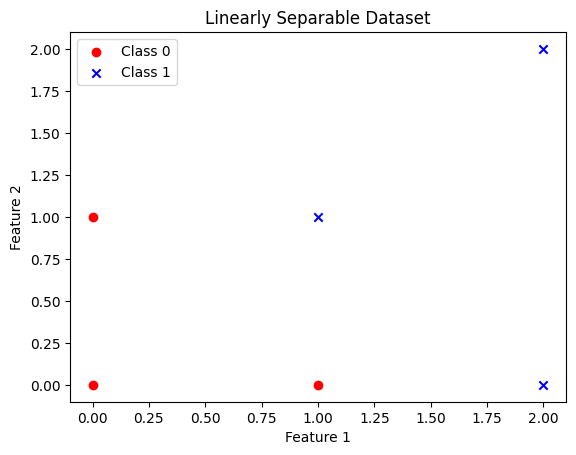

In [ ]:
#Q3-1.
import numpy as np
import matplotlib.pyplot as plt

# Generating a linearly separable dataset
np.random.seed(0)
E = np.array([[1, 1], [2, 2], [2, 0], [0, 0], [1, 0], [0, 1]])
g = np.array([1, 1, 1, 0, 0, 0])

# Plotting the data points
plt.scatter(E[g == 0][:, 0], E[g == 0][:, 1], color='red', marker='o', label='Class 0')
plt.scatter(E[g == 1][:, 0], E[g == 1][:, 1], color='blue', marker='x', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Linearly Separable Dataset')
plt.show()


In [ ]:
# Q3-2. Calculate the optimal logistic neuron weights
log_reg = LogisticRegressionGD(eta=0.05, n_iter=1000)
log_reg.fit(E, g)
print("Optimal weights:", log_reg.w_)

Optimal weights: [-7.06614926  5.16155977  4.19818154]


<ipython-input-214-f03d03a89cdf>:26: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


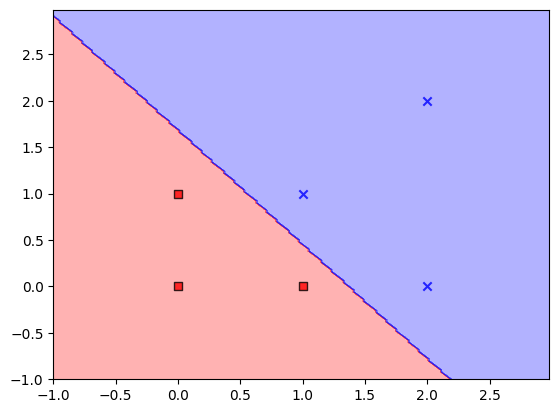

In [ ]:
#Q3-3.
plot_decision_regions(E, g, classifier=log_reg)
plt.show()



In [ ]:
# Grader's area

maxScore = maxScore + 12
#M[3,1] =
#M[3,2] =
#M[3,3] =


<font color = 'blue'> **Q3-4**.  </font> The standard scikit-learn implementation of logistic regression uses regularization by default ($C=1$).  Can you come up with a linearly separable dataset that makes that **default** implementation fail? <br>

[Note: This is an experimental question. You should be able to use the example from above, or modify it, and make the default implementation fail.]

Q3-4. For this experimentation, I stacked data points on 2 X values and set one data point inbetween and played with its class. I noticed that it does create the default implementation to fail because there is a datapoint in the wrong region as shown below.

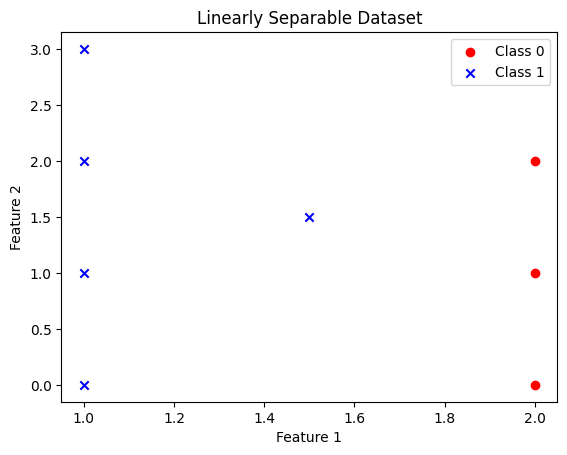

<ipython-input-214-f03d03a89cdf>:26: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


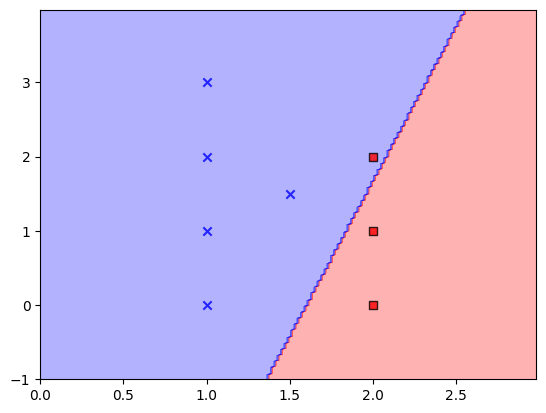

In [ ]:
#Q3-4.
from sklearn.linear_model import LogisticRegression

#changed the dataset to stack and added point inbetween
E = np.array([[1, 0], [1, 1], [1, 2], [1.5, 1.5], [1, 3], [2, 0], [2, 1], [2, 2]])
g = np.array([1, 1, 1, 1, 1, 0, 0, 0])


# Plotting the data points
plt.scatter(E[g == 0][:, 0], E[g == 0][:, 1], color='red', marker='o', label='Class 0')
plt.scatter(E[g == 1][:, 0], E[g == 1][:, 1], color='blue', marker='x', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Linearly Separable Dataset')
plt.show()

# Fittin logistic regression with default parameters
log_reg = LogisticRegression(random_state=42)
log_reg.fit(E, g)

#plotting decision region
plot_decision_regions(E, g, classifier=log_reg)
plt.show()


In [ ]:
# Grader's area
maxScore = maxScore + 4

# M[3,4] =

-----------------------
-----------------------
-----------------------


##  <font color = 'blue'> **Question 4. SVC and classification margin**  </font>

The Iris dataset defined in the above cells is linearly separable.

<font color = 'blue'> **Q4-1.**  </font> Use a [linear SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) to learn a hyperplane $y=w_1x_1 +w_2x_2 +b$ that maximizes the margin for this Iris dataset. In your answer, specify a setting for the hyperparameter $C$ that reduces the amount of regularization (that is, incentivizes very small slacks).

<font color = 'blue'> **Q4-2.** </font> Extract the coefficients $w$ and the intercept $b$ from the learned SVC. Find the the 2-norm of $w$: let $s = \|w\|_2$.
[Hint: Read the documentation in order to access the coefficients.]

<font color = 'blue'> **Q4-3.** </font> Set $w \leftarrow w/s$ and $b\leftarrow b/s$. This changes the numerical definition of the separation line, but the line is still the same.  

<font color = 'blue'> **Q4-4.** </font> With the new $w$ and $b$, calculate $wx^T - b$ for each point $x$ in our dataset. This will give a range of values; let $\gamma$ be the smallest of these in absolute value. This $\gamma$ is the margin. (In fact, there should be two points $x_1$ and $x_2$ of different labels, that give $wx_1^T - b = \gamma$ and $wx_1^T - b = -\gamma$.)


**Note:** as with anything else, feel free to discuss this on Canvas.

Weights (w): [[-0.26553242  0.56312429]]
Intercept (b): [-0.10458066]
The 2-norm of w is: 0.6225884969941771


<ipython-input-214-f03d03a89cdf>:26: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


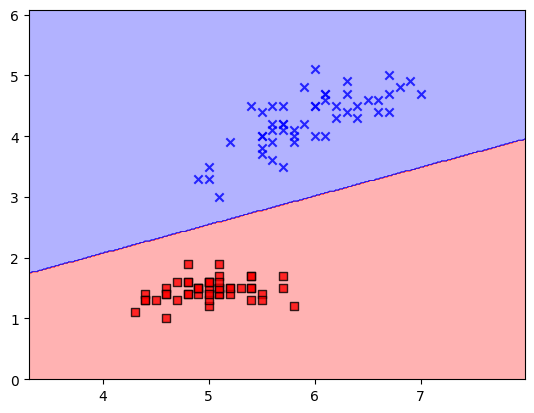

In [ ]:
#Q4-1.
from sklearn.svm import LinearSVC

lsvc = LinearSVC(random_state=1,C=0.01) # used 0.01 for smaller slacks
lsvc.fit(X,y)

print("Weights (w): {}".format(lsvc.coef_)) #finds the weights
print("Intercept (b): {}".format(lsvc.intercept_)) # finds the intercept
w_2_norm = np.linalg.norm(lsvc.coef_)

print("The 2-norm of w is:", w_2_norm)

plot_decision_regions(X,y,lsvc,resolution=0.02)

Q4-2. As calculated in above code. I used C=0.01 for smaller slacks:

Weights (w): [[-0.26553242  0.56312429]]  

Intercept (b): [-0.10458066]

The 2-norm of w is: 0.6225884969941771

In [246]:
#Q4-3. Normalizing w and b - I used chatgpt to help guide me on this. Shown below
w = lsvc.coef_
b = lsvc.intercept_
s = np.linalg.norm(lsvc.coef_)
w_normalized = w / s

b_normalized = b / s

print("Normalized Coefficients (w):", w_normalized)

print("Normalized Intercept (b):", b_normalized)



Normalized Coefficients (w): [[-0.42649748  0.90448875]]
Normalized Intercept (b): [-0.16797717]


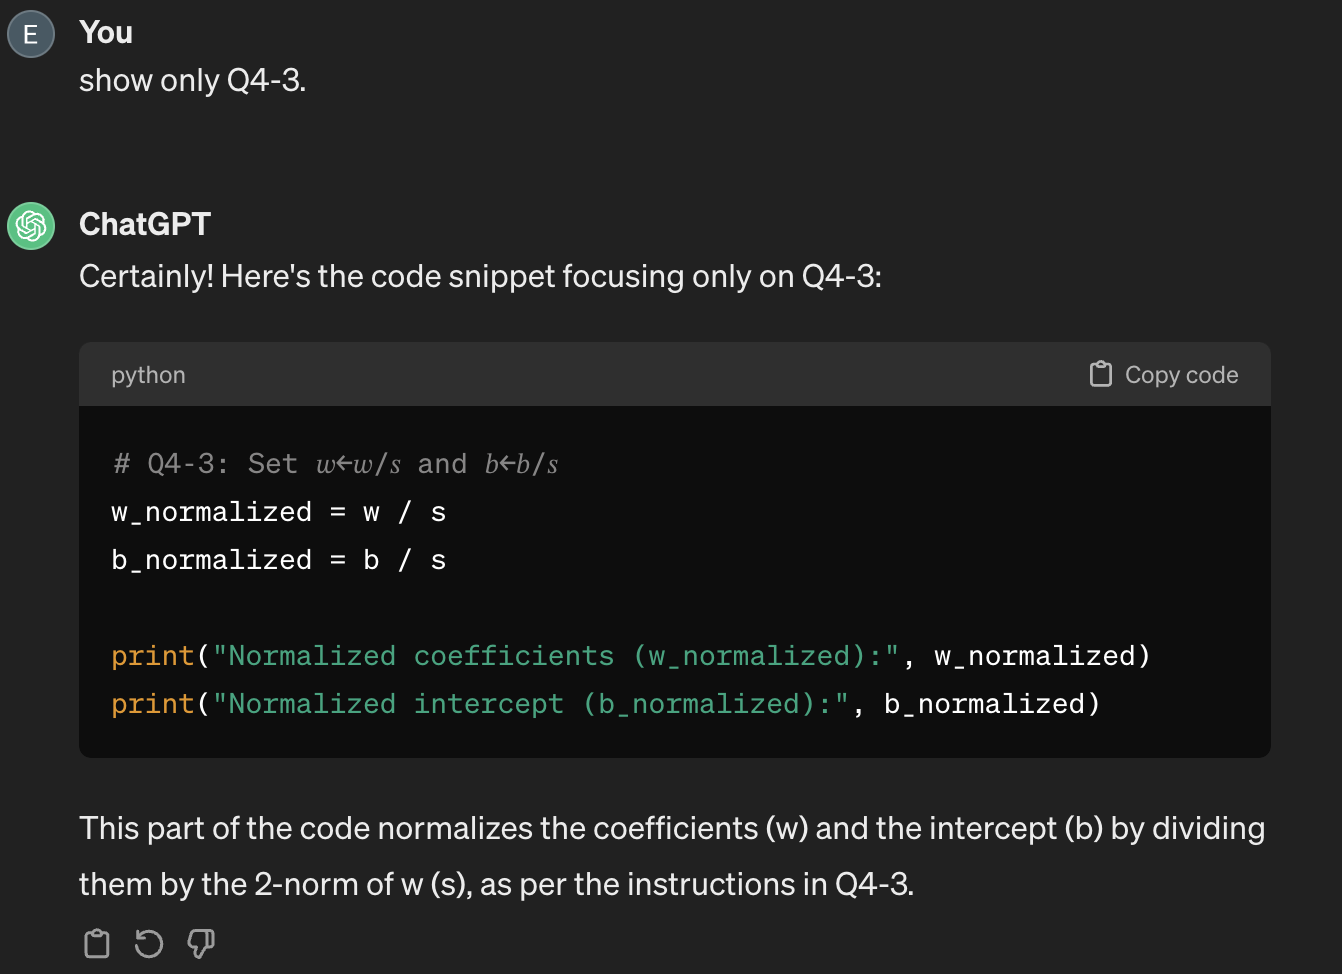

In [247]:
#Q4-4. Finding smallest gamma

distances = lsvc.decision_function(X) / np.linalg.norm(lsvc.coef_)

# Find the smallest distance in absolute value
gamma = np.min(np.abs(distances))

print("Margin (gamma):", gamma)

Margin (gamma): 0.3703519528987685


In [ ]:
# Grader's area

maxScore = maxScore + 16
#M[4,1] =
#M[4,2] =
#M[4,3] =
#M[4,4] =


-----------------------
-----------------------
-----------------------


##  <font color = 'blue'> **Question 5. Upper bound for perceptron errors before convergence**  </font>

In this problem we will use the margin $\gamma$ as calculated in Question 4. If you have not been able to calculate it, you can 'borrow' its value from someone else that has calculated it. (Feel free to share your calculated value of $\gamma$ on Canvas, or to ask your peers to share theirs.)

<font color = 'blue'> **Q5-1.** </font> Calculate $R = \max_{x\in X} \|x\|_2$. In other words, find the 2-norm of all points in the dataset, and let $R$ be the maximum norm.

<font color = 'blue'> **Q5-2.** </font> Calculate $\mathit{maxErrors} = R/\gamma^2$. This is the maximum number of errors that a perceptron can do, in the worst case, before it convergences.

<font color = 'blue'> **Q5-3.** </font> Compare $\mathit{maxErrors}$ with the actual number of errors that the perceptron does with a random initialization. [Hint: Re-use the code from Assignment 2, or anything else that can provide you with that number].  


(If for this question you have used LLMs such as ChatGPT, replace this text by screenshots of the full transcript of your session. Create extra text cells if needed.)

In [ ]:
# Q5-1.
#Calculate the 2-norm of each data point
norms = np.linalg.norm(X, axis=1)

# Find the maximum 2-norm
R = np.max(norms)

print("R:", R)

R: 8.462860036654275


In [ ]:
#Q5-2
R = 8.462860036654275  # Radius of the dataset
maxErrors = R / (gamma ** 2)  # Calculate the maximum number of errors

print("Maximum number of errors:", maxErrors)


Maximum number of errors: 61.70038588620384


In [ ]:
#Q5-3. Re-runnng Perceptron class from A2
class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.
    iterations_ : int
      Number of iterations performed during training.
    weights_history_ : list
      Weights History after each point. #added this new to my code

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []
        self.iterations_ = 0
        self.weights_history_ = [self.w_.copy()]  #added to keep history of weights

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi)) #switched these
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
                self.weights_history_.append(self.w_.copy())  #Stores the weight for each data point
            self.errors_.append(errors)
            self.iterations_ += 1

            # Stop if no errors - made sure to check for errors
            if errors == 0:
                break

        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

In [ ]:
#Q5-3.
# Initializing Perceptron with random initialization
perceptron = Perceptron(eta=0.01, n_iter=1000, random_state=42)

# Fitting the Perceptron to the training data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
perceptron.fit(X_train, y_train)

# Getting the actual number of errors made by the Perceptron during training
errors_perceptron = sum(perceptron.errors_)

print("Number of errors made by perceptron with random initialization:", errors_perceptron)
print("Maximum number of errors (maxErrors):", maxErrors)


Actual number of errors made by perceptron with random initialization: 38527
Maximum number of errors (maxErrors): 61.70038588620384


In [ ]:
# Grader's area

maxScore = maxScore + 12
#M[5,1] =
#M[5,2] =
#M[5,3] =



----------------------------
----------------------------
----------------------------

In [ ]:
#Grader's area

rawScore = np.sum(M)
score = rawScore*100/maxScore